# Introduction

This notebook is an exercise from Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, by Aurélien Geron.

It aims to build different Deep Neural Networks to predict images in the dataset CIFAR-10, availiable in https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

2022-01-24 01:19:54.971198: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-24 01:19:54.971323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-01-24 01:20:00.118067: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-24 01:20:00.121096: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-24 01:20:00.121174: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-24 01:20:00.121224: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (82d7497651d7): /proc/driver/nvidia/version does not exist
2022-01-24 01:20:00.125393: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 2s 0us/step


[1]


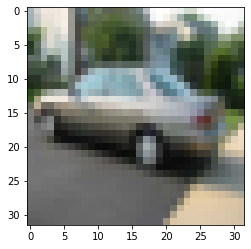

In [4]:
import matplotlib.pyplot as plt

# see random image
some_index = np.random.choice(X_train.shape[0])
some_image = X_train[some_index]
some_label = y_train[some_index]
plt.imshow(some_image)
print(some_label)

In [5]:
# unique values in y_train
y_train_unique = np.unique(y_train)
y_train_unique

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

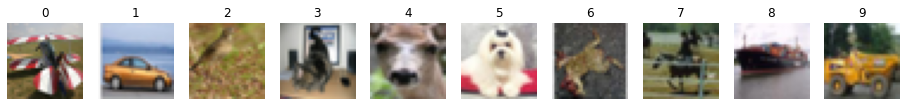

In [6]:
# plot one image from each class in a subplot
fig = plt.figure(figsize=(16, 8))
for label in y_train_unique:
    image_index = np.random.choice(np.where(y_train == label)[0])
    plt.subplot(1, len(y_train_unique), label + 1)
    plt.imshow(X_train[image_index])
    plt.axis('off')
    plt.title(label)

### a)
Build a DNN with 20 hidden layers of 100 neurons each. Use the He initialization and the ELU activation function.

In [7]:
X_train.shape

(45000, 32, 32, 3)

In [8]:
tf.keras.backend.clear_session()
np.random.seed(42)

In [9]:
with tpu_strategy.scope():
    model = keras.models.Sequential()
    for i in range(21):
        if i == 0:
            model.add(keras.layers.Flatten(input_shape=(32, 32, 3)))
        else:
            model.add(keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Nadam(),
                metrics=['accuracy'])

## b)
Using Nadam Optimization and early stopping, train the network.

In [10]:
# Using Nadam Optimization and early stopping, train the network.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint = keras.callbacks.ModelCheckpoint('cifar10_model.h5', save_best_only=True)
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping, model_checkpoint],
                    batch_size=BATCH_SIZE)

Epoch 1/100
352/352 [==============================] - 21s 29ms/step - loss: 15.4664 - accuracy: 0.1508 - val_loss: 2.0135 - val_accuracy: 0.2698
Epoch 2/100
352/352 [==============================] - 6s 17ms/step - loss: 2.0271 - accuracy: 0.2563 - val_loss: 2.0057 - val_accuracy: 0.2554
Epoch 3/100
352/352 [==============================] - 6s 17ms/step - loss: 1.9329 - accuracy: 0.2933 - val_loss: 2.0733 - val_accuracy: 0.2702
Epoch 4/100
352/352 [==============================] - 6s 17ms/step - loss: 1.8852 - accuracy: 0.3123 - val_loss: 1.9752 - val_accuracy: 0.2818
Epoch 5/100
352/352 [==============================] - 6s 17ms/step - loss: 1.8252 - accuracy: 0.3371 - val_loss: 1.7782 - val_accuracy: 0.3540
Epoch 6/100
352/352 [==============================] - 6s 17ms/step - loss: 1.7836 - accuracy: 0.3532 - val_loss: 1.7376 - val_accuracy: 0.3676
Epoch 7/100
352/352 [==============================] - 6s 17ms/step - loss: 1.7587 - accuracy: 0.3670 - val_loss: 1.7472 - val_accurac

In [11]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# subplots of loss and accuracy

def compare_loss_acc(history):
    # returns a plotly figure of the loss and accuracy curves for training and validation
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], name='Validation Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], name='Training Accuracy'), row=1, col=2)
    fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], name='Validation Accuracy'), row=1, col=2)
    fig.update_layout(height=600, width=1000)
    return fig

In [12]:
fig = compare_loss_acc(history)
fig.show()

## c)
Add Batch Normalization and compare the learning curves

In [13]:
tf.keras.backend.clear_session()
np.random.seed(42)

In [14]:
with tpu_strategy.scope():
    model_batch = keras.models.Sequential()
    for i in range(21):
        if i == 0:
            model_batch.add(keras.layers.Flatten(input_shape=(32, 32, 3)))
            model_batch.add(keras.layers.BatchNormalization())
        else:
            model_batch.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
            model_batch.add(keras.layers.BatchNormalization())
            model_batch.add(keras.layers.Activation('elu'))
    model_batch.add(keras.layers.Dense(10, activation='softmax'))
    model_batch.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Nadam(),
                metrics=['accuracy'])

In [15]:
model_batch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [16]:
model_checkpoint = keras.callbacks.ModelCheckpoint('cifar10_model_bn.h5', save_best_only=True)
history_batch = model_batch.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
                                callbacks=[early_stopping, model_checkpoint],
                                batch_size=BATCH_SIZE)

Epoch 1/100
352/352 [==============================] - 39s 41ms/step - loss: 2.0776 - accuracy: 0.2563 - val_loss: 1.6878 - val_accuracy: 0.4042
Epoch 2/100
352/352 [==============================] - 7s 20ms/step - loss: 1.7808 - accuracy: 0.3650 - val_loss: 1.6466 - val_accuracy: 0.4066
Epoch 3/100
352/352 [==============================] - 7s 20ms/step - loss: 1.7118 - accuracy: 0.3901 - val_loss: 1.5762 - val_accuracy: 0.4306
Epoch 4/100
352/352 [==============================] - 7s 20ms/step - loss: 1.6747 - accuracy: 0.4002 - val_loss: 1.5111 - val_accuracy: 0.4584
Epoch 5/100
352/352 [==============================] - 7s 20ms/step - loss: 1.6320 - accuracy: 0.4201 - val_loss: 1.4791 - val_accuracy: 0.4738
Epoch 6/100
352/352 [==============================] - 7s 20ms/step - loss: 1.6208 - accuracy: 0.4259 - val_loss: 1.4534 - val_accuracy: 0.4786
Epoch 7/100
352/352 [==============================] - 7s 20ms/step - loss: 1.5938 - accuracy: 0.4356 - val_loss: 1.4595 - val_accuracy

In [17]:
def compare_lr_curves(history_1, history_1_name, history_2, history_2_name):
    # compare the learning curves of the two models
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Scatter(x=history_1.epoch, y=history_1.history['loss'], name=history_1_name+" Training Loss"), row=1, col=1)
    fig.add_trace(go.Scatter(x=history_1.epoch, y=history_1.history['val_loss'], name=history_1_name+" Validation Loss"), row=1, col=1)
    fig.add_trace(go.Scatter(x=history_1.epoch, y=history_1.history['accuracy'], name=history_1_name+" Training Accuracy"), row=1, col=2)
    fig.add_trace(go.Scatter(x=history_1.epoch, y=history_1.history['val_accuracy'], name=history_1_name+" Validation Accuracy"), row=1, col=2)
    fig.add_trace(go.Scatter(x=history_2.epoch, y=history_2.history['loss'], name=history_2_name+" Training Loss"), row=1, col=1)
    fig.add_trace(go.Scatter(x=history_2.epoch, y=history_2.history['val_loss'], name=history_2_name+" Validation Loss"), row=1, col=1)
    fig.add_trace(go.Scatter(x=history_2.epoch, y=history_2.history['accuracy'], name=history_2_name+" Training Accuracy"), row=1, col=2)
    fig.add_trace(go.Scatter(x=history_2.epoch, y=history_2.history['val_accuracy'], name=history_2_name+" Validation Accuracy"), row=1, col=2)
    
    ## update color of traces
    fig.data[0].update(marker_color='#ff0000')
    fig.data[1].update(marker_color='#800000')
    fig.data[2].update(marker_color='#ff0000')
    fig.data[3].update(marker_color='#800000')
    fig.data[4].update(marker_color='#4da6ff')
    fig.data[5].update(marker_color='#0059b3')
    fig.data[6].update(marker_color='#4da6ff')
    fig.data[7].update(marker_color='#0059b3')
    
    # update layout
    fig.update_layout(height=600, width=1000, template='plotly_white')
    return fig
    

In [18]:
fig = compare_lr_curves(history_batch, "Batch Normalization", history, "No Batch Normalization")
fig.show()

We can see a huge improvement in both accuracy and loss! With a huge stack of Dense layers (20), probably the gradients of some hidden layers were vanishing or exploding. That's why we had some inconstant training in the first model and a big improvement with Batch Normalization.

## d)
Replace Batch Normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes

In [19]:
tf.keras.backend.clear_session()
np.random.seed(42)

In [20]:
X_train.shape

(45000, 32, 32, 3)

In [21]:
# standardize the data
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [22]:
# DNN with SELU activation
with tpu_strategy.scope():
    model_selu = keras.models.Sequential()
    for i in range(21):
        if i == 0:
            model_selu.add(keras.layers.Flatten(input_shape=(32, 32, 3)))
        else:
            model_selu.add(keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_normal"))
    model_selu.add(keras.layers.Dense(10, activation='softmax'))
    model_selu.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Nadam(),
                metrics=['accuracy'])

In [23]:
model_selu.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [24]:
model_checkpoint = keras.callbacks.ModelCheckpoint('cifar10_model_selu.h5', save_best_only=True)
history_selu = model_selu.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), 
                              callbacks=[early_stopping, model_checkpoint],
                              batch_size=BATCH_SIZE)

Epoch 1/100
352/352 [==============================] - 21s 29ms/step - loss: 2.0557 - accuracy: 0.2688 - val_loss: 1.7829 - val_accuracy: 0.3644
Epoch 2/100
352/352 [==============================] - 6s 17ms/step - loss: 1.6888 - accuracy: 0.4005 - val_loss: 1.7135 - val_accuracy: 0.3916
Epoch 3/100
352/352 [==============================] - 6s 17ms/step - loss: 1.5713 - accuracy: 0.4460 - val_loss: 1.6027 - val_accuracy: 0.4462
Epoch 4/100
352/352 [==============================] - 6s 18ms/step - loss: 1.4822 - accuracy: 0.4787 - val_loss: 1.5652 - val_accuracy: 0.4430
Epoch 5/100
352/352 [==============================] - 6s 17ms/step - loss: 1.4323 - accuracy: 0.4941 - val_loss: 1.5385 - val_accuracy: 0.4654
Epoch 6/100
352/352 [==============================] - 6s 17ms/step - loss: 1.3683 - accuracy: 0.5187 - val_loss: 1.4959 - val_accuracy: 0.4764
Epoch 7/100
352/352 [==============================] - 6s 17ms/step - loss: 1.3226 - accuracy: 0.5362 - val_loss: 1.4929 - val_accuracy

In [25]:
fig = compare_lr_curves(history_selu, "SELU Activation", history_batch, "Batch Normalization")
fig.show()

## e)
Try regularizing the model with alpha dropout, and compare with Dropout only.

In [26]:
# add alpha dropout
# DNN with SELU activation
with tpu_strategy.scope():
    model_alpha = keras.models.Sequential()
    for i in range(21):
        if i == 0:
            model_alpha.add(keras.layers.Flatten(input_shape=(32, 32, 3)))
            model_alpha.add(keras.layers.AlphaDropout(0.1))
        else:
            model_alpha.add(keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_normal"))
            model_alpha.add(keras.layers.AlphaDropout(0.1))
    model_alpha.add(keras.layers.Dense(10, activation='softmax'))
    model_alpha.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Nadam(),
                metrics=['accuracy'])

In [27]:
model_alpha.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               307300    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)              

In [28]:
model_checkpoint = keras.callbacks.ModelCheckpoint('cifar10_model_alpha.h5', save_best_only=True)
history_alpha = model_alpha.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), 
                                callbacks=[early_stopping, model_checkpoint], batch_size=BATCH_SIZE)

Epoch 1/100
352/352 [==============================] - 23s 29ms/step - loss: 2.4402 - accuracy: 0.1494 - val_loss: 3.4392 - val_accuracy: 0.2046
Epoch 2/100
352/352 [==============================] - 7s 20ms/step - loss: 2.0047 - accuracy: 0.2228 - val_loss: 5.5217 - val_accuracy: 0.2202
Epoch 3/100
352/352 [==============================] - 6s 17ms/step - loss: 1.9112 - accuracy: 0.2721 - val_loss: 4.4721 - val_accuracy: 0.2382
Epoch 4/100
352/352 [==============================] - 6s 17ms/step - loss: 1.8563 - accuracy: 0.2874 - val_loss: 5.0211 - val_accuracy: 0.3036
Epoch 5/100
352/352 [==============================] - 6s 17ms/step - loss: 1.8092 - accuracy: 0.3163 - val_loss: 5.0511 - val_accuracy: 0.3070
Epoch 6/100
352/352 [==============================] - 6s 17ms/step - loss: 1.7794 - accuracy: 0.3266 - val_loss: 7.6891 - val_accuracy: 0.3194
Epoch 7/100
352/352 [==============================] - 6s 17ms/step - loss: 1.7674 - accuracy: 0.3293 - val_loss: 6.1595 - val_accuracy

In [29]:
compare_lr_curves(history_alpha, "Alpha Dropout", history_selu, "w/o Alpha Dropout")

With Alpha Dropout, our model didn't overfit like the previous one, but the model with Batch Normalization Layers performed way better.

In [30]:
best_model = keras.models.load_model('cifar10_model_bn.h5')
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 10ms/step - loss: 1.3064 - accuracy: 0.5372


[1.3064104318618774, 0.5371999740600586]

53% of accuracy on the test set. Not bad! I will try to improve this performance in future notebook with CNNs. Make sure to check it out, and let me know how can I improve my work! Thank you!